In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time


## Backgound removal

The yawn and no-yawn images have backgound. so remove the backgorund

In [12]:
# Load the cascade
face_cascade = cv2.CascadeClassifier('data/haar/haarcascade_frontalface_default.xml')
# Load the image
img_path = 'data/train/yawn/5.jpg'
img = cv2.imread(img_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect the faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw the rectangle around each face
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
# Display
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
img.shape

(480, 640, 3)

In [14]:
img_path = 'data/train/yawn/5.jpg'

# Cropping an image
cropped_image = img[0:400, 220:550]
 
# Display cropped image
cv2.imshow("cropped", cropped_image)
 
# Save the cropped image
cv2.imwrite("Cropped Image.jpg", cropped_image)
 
cv2.waitKey(0)
cv2.destroyAllWindows()

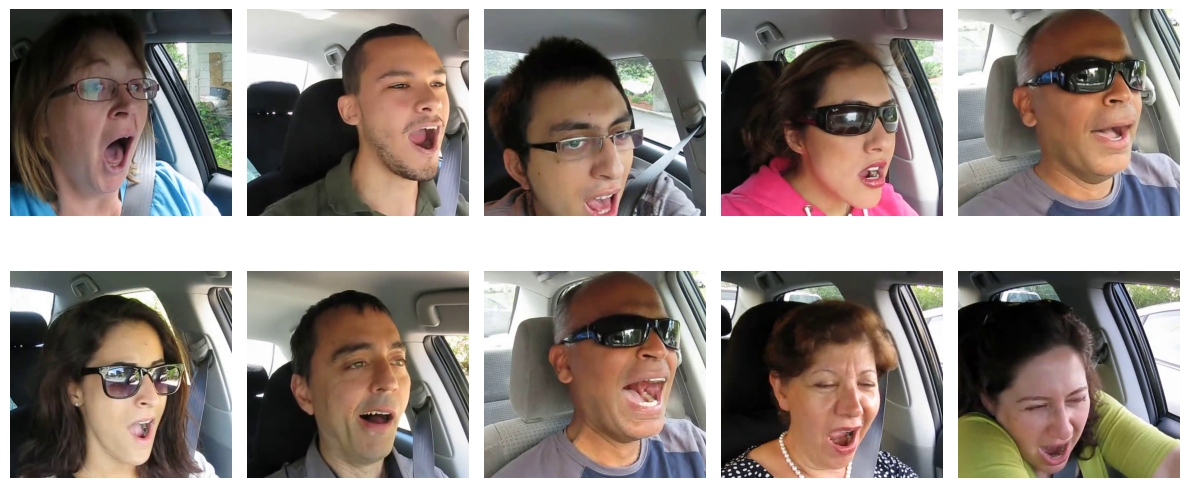

In [15]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directory path
dir_path = 'data/train/yawn/'

# Get a list of all image filenames in the directory
image_files = os.listdir(dir_path)

# Randomly select 10 image filenames
selected_images = np.random.choice(image_files, size=10, replace=False)

# Create a subplot of 10 images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

# Loop over the selected images and crop them
for i, image_file in enumerate(selected_images):
    # Load the image
    img_path = os.path.join(dir_path, image_file)
    img = cv2.imread(img_path)
    
    # Crop the image
    cropped_image = img[0:400, 120:550]
    
    # Convert BGR to RGB format for plotting
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    
    # Display the cropped image in the subplot
    axs[i].imshow(cropped_image)
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
class DrowsyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)

    def __len__(self):
        length = 0
        for c in self.classes:
            class_dir = os.path.join(self.root_dir, c)
            length += len(os.listdir(class_dir))
        return length

    def __getitem__(self, idx):
        

        img_label = None
        class_idx = 0

        for c in self.classes:
            class_dir = os.path.join(self.root_dir, c)
            if idx < len(os.listdir(class_dir)):
                img_name = os.listdir(class_dir)[idx]
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_label = c
                break
            else:
                idx -= len(os.listdir(class_dir))
                class_idx += 1

        # Convert image to PIL format
        pil_img = Image.fromarray(img)

        if self.transform:
            pil_img = self.transform(pil_img)

        
        if img_label in ["yawn", "no_yawn"]:
        
            # Crop the image
            cropped_image = img[0:400, 120:550]

            # Convert the image to PIL format and apply the transform
            pil_img = transforms.ToPILImage()(cropped_image)
            
            if self.transform:
                pil_img = self.transform(pil_img)
            else:
                
                pil_img = None
                class_idx = None

        return pil_img, class_idx



In [26]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

# Define transforms to be applied on the images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the custom dataset class for train, validation and test data
dataset = DrowsyDataset('data/train/', data_transforms)



In [33]:
from sklearn.model_selection import train_test_split

# Get the labels from the dataset
labels = np.array([label for _, label in dataset])

# Split the dataset into train and test sets, stratified by the target variable
train_data, test_data = train_test_split(dataset, test_size=0.2, stratify=dataset.targets, random_state=42)

# Print the sizes of train and test sets
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))


# Define batch size for DataLoader
batch_size = 32

# Create DataLoader instances for train, validation and test data
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

UnboundLocalError: local variable 'img' referenced before assignment

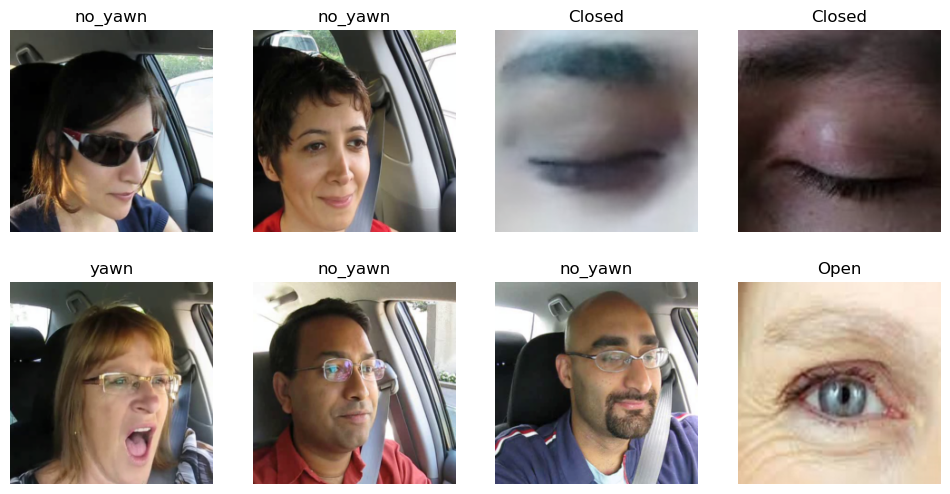

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and their corresponding labels
images, labels = next(iter(train_loader))

# Convert images to numpy arrays and unnormalize them
image_array = images.numpy()
image_array = np.transpose(image_array, (0, 2, 3, 1))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_array = std * image_array + mean
image_array = np.clip(image_array, 0, 1)

# Define a list of class names
class_names = train_data.classes

# Plot the images with their corresponding labels
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(8):
    img = image_array[i]
    label = class_names[labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()


In [20]:
import torch.optim as optim
from torchvision.models import alexnet

# Define the AlexNet model
model = alexnet(pretrained=True)

# Replace the last fully connected layer with a new one for the number of classes in your dataset
num_classes = len(train_data.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)



In [24]:
from tqdm import tqdm_notebook as tqdm

In [25]:
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Update progress bar description
        progress_bar.set_postfix(loss=f"{running_loss / (len(progress_bar) * batch_size):.4f}")

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

C:\Users\adity\AppData\Local\Temp\ipykernel_8376\3188091919.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)


Epoch 1/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.3551


Epoch 2/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0763


Epoch 3/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0363


Epoch 4/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0238


Epoch 5/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0165


Epoch 6/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0138


Epoch 7/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0051


Epoch 8/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0060


Epoch 9/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0079


Epoch 10/10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0020


## Evaluation

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

# Initialize lists to store the predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass to get the predicted probabilities
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Append the predicted labels and true labels to the lists
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Compute the test metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the test metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
